# Calibrate Template Mixture Priors

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
import emcee
import corner

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')



comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

In [3]:
def approx_flux_likelihood_multiobj(
        f_obs,  # no, nf
        f_obs_var,  # no, nf
        f_mod,  # no, nt, nf
        ell_hat,  # 1
        ell_var,  # 1
        returnChi2=False,
        normalized=True):

    assert len(f_obs.shape) == 2
    assert len(f_obs_var.shape) == 2
    assert len(f_mod.shape) == 3
    no, nt, nf = f_mod.shape
    f_obs_r = f_obs[:, None, :]
    var = f_obs_var[:, None, :]
    invvar = np.where(f_obs_r/var < 1e-6, 0.0, var**-1.0)  # nz * nt * nf
    FOT = np.sum(f_mod * f_obs_r * invvar, axis=2)\
        + ell_hat / ell_var  # no * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)\
        + 1. / ell_var  # no * nt
    FOO = np.sum(f_obs_r**2 * invvar, axis=2)\
        + ell_hat**2 / ell_var  # no * nt
    sigma_det = np.prod(var, axis=2)
    chi2 = FOO - FOT**2.0 / FTT  # no * nt
    denom = np.sqrt(FTT)
    if normalized:
        denom *= np.sqrt(sigma_det * (2*np.pi)**nf * ell_var)
    like = np.exp(-0.5*chi2) / denom  # no * nt
    if returnChi2:
        return chi2
    else:
        return like


In [4]:
def lnprob(params, nt, allFluxes, allFluxesVar, zZmax, fmod_atZ, pmin, pmax):
    if np.any(params > pmax) or np.any(params < pmin):
        return - np.inf

    alphas0 = dirichlet(params[0:nt], rsize=1).ravel()[None, :]  # 1, nt
    alphas1 = dirichlet(params[nt:2*nt], rsize=1).ravel()[None, :]  # 1, nt
    alphas_atZ = zZmax[:, None] * (alphas1 - alphas0) + alphas0  # no, nt
    # fmod_atZ: no, nt, nf
    fmod_atZ_t = (fmod_atZ * alphas_atZ[:, :, None]).sum(axis=1)[:, None, :]
    # no, 1, nf
    sigma_ell = 1e3
    like_grid = approx_flux_likelihood_multiobj(allFluxes, allFluxesVar, fmod_atZ_t, 1, sigma_ell**2.).ravel()  # no,
    eps = 1e-305
    ind = like_grid > eps
    theprob = np.log(like_grid[ind]).sum()
    return theprob


    

In [5]:
def plot_params(params):
    fig, axs = plt.subplots(4, 4, figsize=(16, 8))
    axs = axs.ravel()
    alphas = params[0:nt]
    alpha0 = np.sum(alphas)
    dirsamples = dirichlet(alphas, 1000)
    for i in range(nt):
        mean = alphas[i]/alpha0
        std = np.sqrt(alphas[i] * (alpha0-alphas[i]) / alpha0**2 / (alpha0+1))
        axs[i].axvspan(mean-std, mean+std, color='gray', alpha=0.5)
        axs[i].axvline(mean, c='k', lw=2)
        axs[i].axvline(1/nt, c='k', lw=1, ls='dashed')
        axs[i].set_title('alpha0 = '+str(alphas[i]))
        axs[i].set_xlim([0, 1])
        axs[i].hist(dirsamples[:, i], 50, color="k", histtype="step")
    alphas = params[nt:2*nt]
    alpha0 = np.sum(alphas)
    dirsamples = dirichlet(alphas, 1000)
    for i in range(nt):
        mean = alphas[i]/alpha0
        std = np.sqrt(alphas[i] * (alpha0-alphas[i]) / alpha0**2 / (alpha0+1))
        axs[nt+i].axvspan(mean-std, mean+std, color='gray', alpha=0.5)
        axs[nt+i].axvline(mean, c='k', lw=2)
        axs[nt+i].axvline(1/nt, c='k', lw=1, ls='dashed')
        axs[nt+i].set_title('alpha1 = '+str(alphas[i]))
        axs[nt+i].set_xlim([0, 1])
        axs[nt+i].hist(dirsamples[:, i], 50, color="k", histtype="step")
    fig.tight_layout()
    return fig

In [6]:
!ls tmp

delight_data  parametersTest.cfg


In [7]:
configfilename= "tmp/parametersTest.cfg"

In [8]:
logger.info("--- calibrate Template Mixture Priors ---")

paramFileName = configfilename
params = parseParamFile(paramFileName, verbose=True)
#params = parseParamFile(paramFileName, verbose=False)

2021-03-11 22:56:53,894 ipykernel_launcher.py __main__[271] INFO --- calibrate Template Mixture Priors ---
2021-03-11 22:56:53,903 ipykernel_launcher.py, delight.io[271] WARNING Input parameter file:tmp/parametersTest.cfg
2021-03-11 22:56:53,904 ipykernel_launcher.py, delight.io[271] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g 

In [9]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [10]:
numZ = redshiftGrid.size

In [11]:
# Locate which columns of the catalog correspond to which bands.
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="training_")

In [12]:
bandIndices

array([0, 1, 2, 3, 4, 5])

In [13]:
bandNames

array(['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y'],
      dtype='<U6')

In [14]:
bandColumns

array([ 0,  2,  4,  6,  8, 10])

In [15]:
bandVarColumns

array([ 1,  3,  5,  7,  9, 11])

In [16]:
redshiftColumn

12

In [17]:
refBandColumn

6

In [18]:
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']

In [19]:
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
numBands = bandIndices.size
nt = len(sed_names)

In [20]:
f_mod = np.zeros((numZ, nt, len(params['bandNames'])))

In [21]:
# model of flux-redshift for each template
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [22]:
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

<ipython-input-22-67f73946292d>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [23]:
msg = 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)

2021-03-11 22:56:54,577 ipykernel_launcher.py __main__[271] INFO Number of Training Objects 10225


In [24]:
numMetrics = 7 + len(params['confidenceLevels'])

In [25]:
allFluxes = np.zeros((numObjectsTraining, numBands))
allFluxesVar = np.zeros((numObjectsTraining, numBands))

redshifts = np.zeros((numObjectsTraining, 1))
fmod_atZ = np.zeros((numObjectsTraining, nt, numBands))

In [26]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(params, 0, numObjectsTraining,prefix="training_", getXY=False)

In [27]:
# loop on traning
for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
    
    
    allFluxes[loc, :] = fluxes
    allFluxesVar[loc, :] = fluxesVar
    redshifts[loc, 0] = z
    

    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZ[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

In [28]:
zZmax = redshifts[:, 0] / redshiftGrid[-1]

In [29]:
pmin = np.repeat(0., 2*nt)
pmax = np.repeat(200., 2*nt)

ndim, nwalkers = 2*nt, 100
p0 = [pmin + (pmax-pmin)*np.random.uniform(0, 1, size=ndim) for i in range(nwalkers)]

for i in range(10):
    print(lnprob(p0[i], nt, allFluxes, allFluxesVar, zZmax, fmod_atZ, pmin, pmax))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=4,args=[nt, allFluxes, allFluxesVar, zZmax,fmod_atZ, pmin, pmax])
pos, prob, state = sampler.run_mcmc(p0, 200)
sampler.reset()
sampler.run_mcmc(pos, 2000)
print("Mean acceptance fraction: {0:.3f}" .format(np.mean(sampler.acceptance_fraction)))
samples = sampler.chain.reshape((-1, ndim))
lnprob = sampler.lnprobability.reshape((-1, 1))

params_mean = samples.mean(axis=0)
params_std = samples.std(axis=0)



174510.7818179495
-124720.06009909265
40177.64745091976
-1490.1954761726156
-84050.60946991692
-54280.242453498504
5790.310146581673
-3496.4998883273656
183292.3015223526
-86716.98443893951
Mean acceptance fraction: 0.009


params_mean [ 27.06305743 170.13569125 125.20821538  39.67687218   7.62863293
  70.32078673   9.18931928   2.20031321 141.39542972 142.83633175
 150.43997233  69.68753655  86.44473204  56.36351681 114.52769246
  73.19984423]
params_std [21.37093832 13.47204998 19.32753463 13.99362056  6.39127368 21.16943842
  4.55916776  1.7349116  16.17280003 19.13669971 27.99809088 25.68047638
 19.18441662 11.71494465 18.43549896  8.24006861]
alpha0: 0.06, 0.38, 0.28, 0.088, 0.017, 0.16, 0.02, 0.0049
alpha0 err: 0.011, 0.023, 0.021, 0.013, 0.0061, 0.017, 0.0066, 0.0033
alpha1: 0.17, 0.17, 0.18, 0.083, 0.1, 0.068, 0.14, 0.088
alpha1 err: 0.013, 0.013, 0.013, 0.0096, 0.011, 0.0087, 0.012, 0.0098


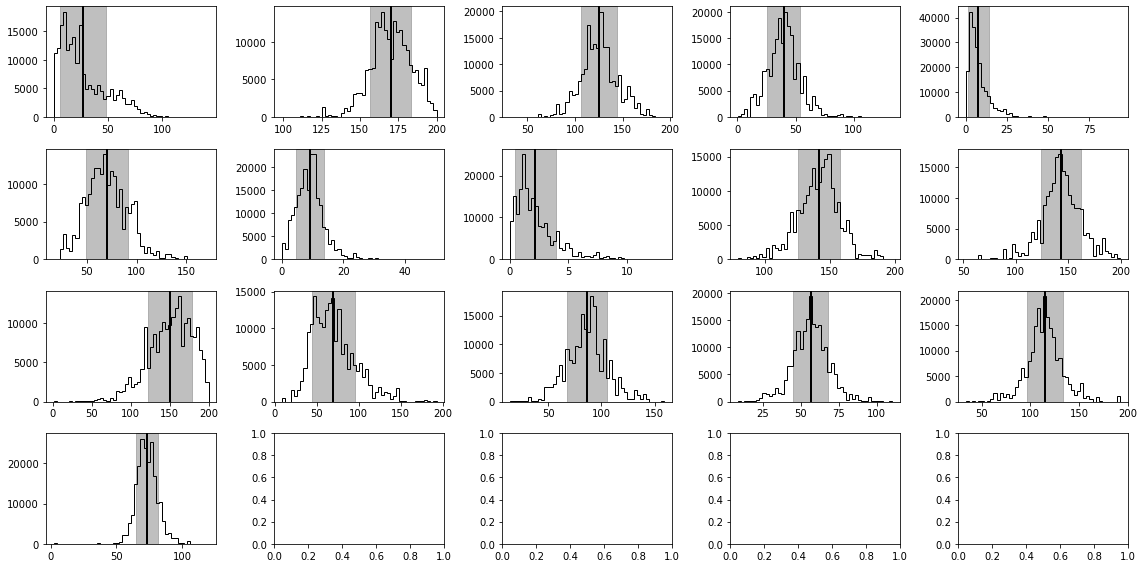

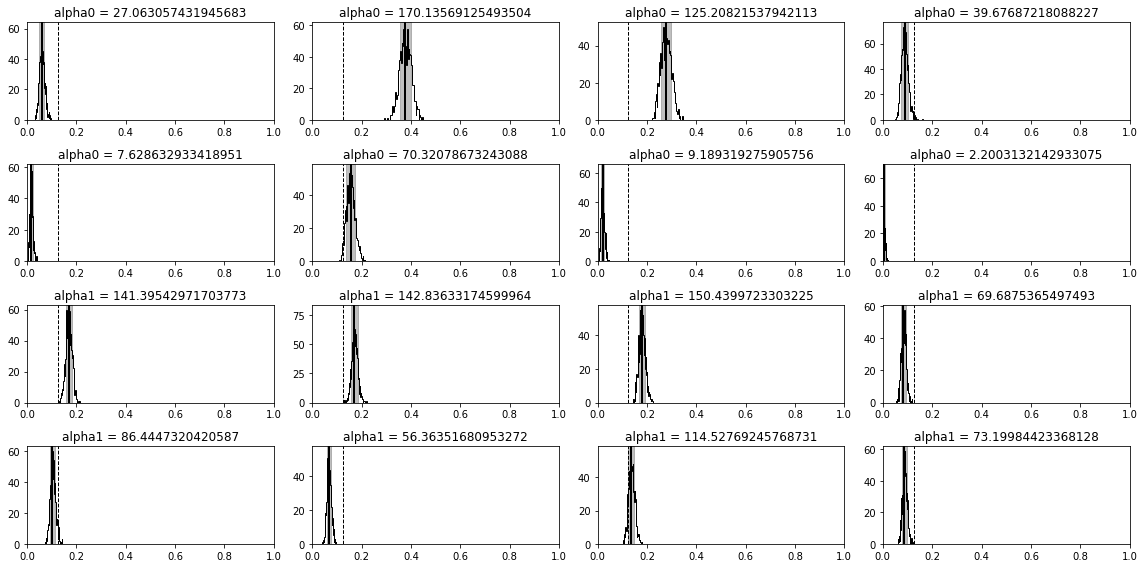

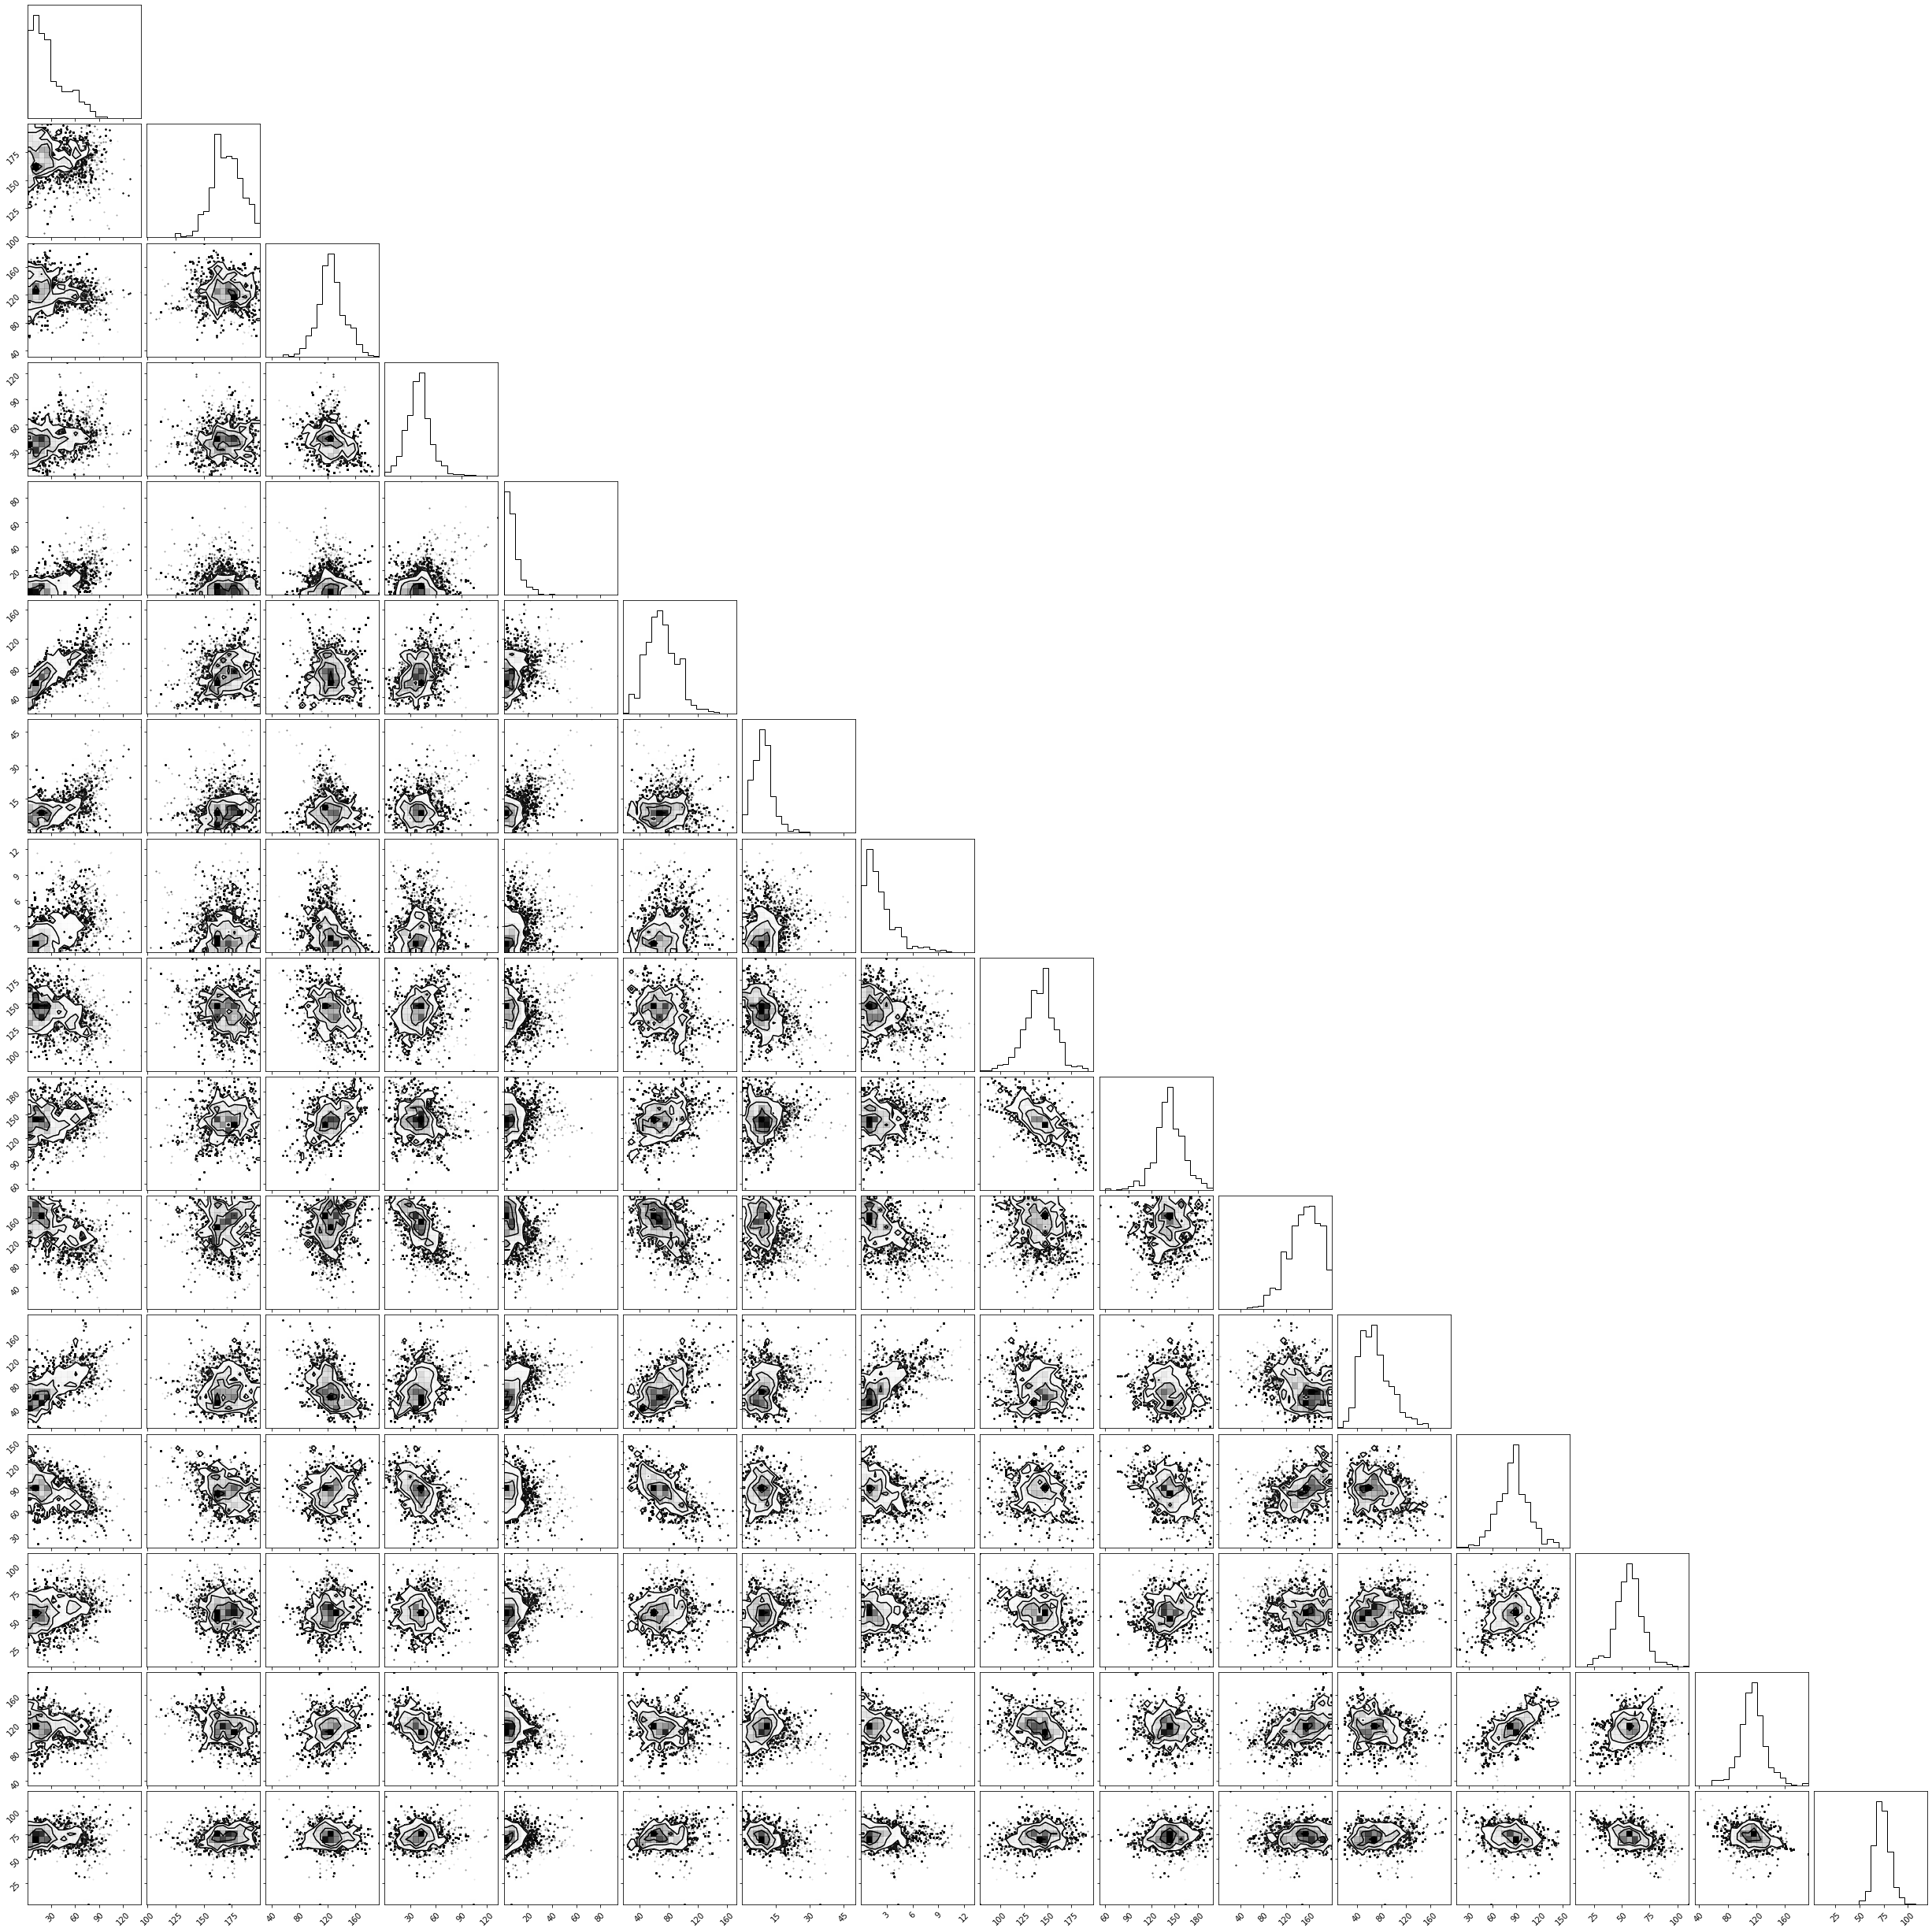

In [30]:
fig, axs = plt.subplots(4, 5, figsize=(16, 8))
axs = axs.ravel()
for i in range(ndim):
    axs[i].hist(samples[:, i], 50, color="k", histtype="step")
    axs[i].axvspan(params_mean[i]-params_std[i],params_mean[i]+params_std[i], color='gray', alpha=0.5)
    axs[i].axvline(params_mean[i], c='k', lw=2)
fig.tight_layout()
fig.savefig('priormixture_parameters.pdf')

fig = plot_params(params_mean)
fig.savefig('priormixture_meanparameters.pdf')

print("params_mean", params_mean)
print("params_std", params_std)

alphas = params_mean[0:nt]
alpha0 = np.sum(alphas)
print("alpha0:", ', '.join(['%.2g' % x for x in alphas / alpha0]))
print("alpha0 err:", ', '.join(['%.2g' % x for x in np.sqrt(alphas*(alpha0-alphas)/alpha0**2/(alpha0+1))]))

alphas = params_mean[nt:2*nt]
alpha0 = np.sum(alphas)
print("alpha1:", ', '.join(['%.2g' % x for x in alphas / alpha0]))
print("alpha1 err:", ', '.join(['%.2g' % x for x in np.sqrt(alphas*(alpha0-alphas)/alpha0**2/(alpha0+1))]))

fig = corner.corner(samples)
fig.savefig("trianglemixture.pdf")